# Code validation

**Validation status: <font color="green">PASSED!</font>**

**Commit: [9b79b37490b835131deb7b150d901fb8360c3fd2](https://github.com/leowerneck/Tabulated_EOS_IllinoisGRMHD/commit/9b79b37490b835131deb7b150d901fb8360c3fd2)**

These notes are intended to show partial validations of the modifications we are making to the `IllinoisGRMHD` thorn and its dependencies (`ID_converter_ILGRMHD` and `Convert_to_HydroBase`).

# Key modifications

Major modifications, in particular cleanups, to the conservative-to-primitive routines have been performed. While we already started adding tabulated EOS related stuff, our goal here is to make sure that the modifications we made to the code do not break it. Some modifications highlights:

1. Added new parameters to the code which allow us to change, using the parameter file:
    * The EOS type
    * The con2prim routine
    * The "extra" PPM reconstructed variable (e.g. the pressure for Hybrid EOS)
    * Whether or not to evolve the entropy
    * Whether or not to evolve the temperature
    * How long should we wait before we begin evolving the temperature
    * Table ceilings/floors safety factors
    * Root finding precision for EOS tables (for table inversions)
1. Fixed several issues with the C code that bothered me. For example, the hybrid EOS source code is now compiled, instead of being included as a header.
1. Added new functions to get an EOS "handle" or "key", which is an integer that selects which EOS we want to use.
1. Piecewise polytropic EOS is now called Hybrid, which is what it should've been called in the first place.
1. Added new functions to simplify the conservative-to-primitive interface.
1. Made the conservative-to-primitive function arguments universal.
1. Removed extra steps in setting conservatives and primitives for the Noble *et al.* con2prim.

# Test details

Our code validation test consists of the Binary Neutron Star run on a adaptive mesh refinement (AMR) grid with 4 refinement levels. We compare results between the trusted version of the code and the new version of the code, demonstrating agreement between the two during the first 1000 time integration steps (a 4th order Runge-Kutta time integrator is used).

Details:

* **Test type**: Hybrid EOS vs Hybrid EOS (standard evolution)
* **ETK version**: ET_2020_11

* **Trusted IGM version**: nrpytutorial (Jan 24, 2020)

* **Tested IGM version**: Tabulated_EOS_IllinoisGRMHD (see commit version above)

* **Initial data file**: LORENE equal mass BNS with 1.4 solar masses and 50km initial separation (available [here](https://ccrgpages.rit.edu/~jfaber/BNSID/Data/Sly/Sly_1.4_1.4/), file `resu_5.000000e+01_1.550000e+00_1.550000e+00.d`)

* **Parameter file**: available in output directories of this validation test

# Validation results

We present results for the minimum lapse and maximum baryon density as a function of time. We also show the BNS trajectories.

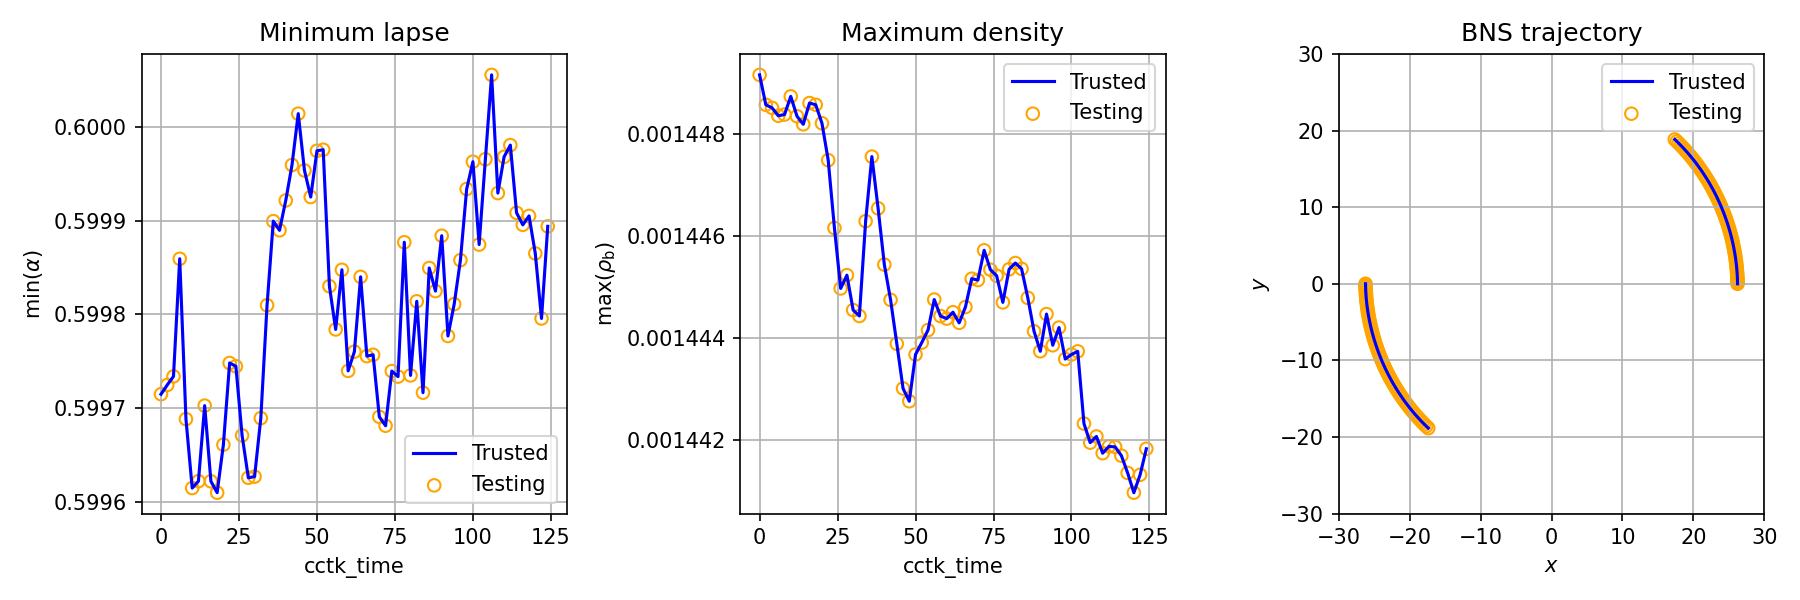

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

# Get current working directory
base_dir    = os.getcwd()

# Now set the output directories, which contains
# results from the trusted version of the code
# and the version we are currently testing
dir_trusted = os.path.join(base_dir,"out_trusted")
dir_testing = os.path.join(base_dir,"out_testing")

# Read in the data files
alp_trusted = np.loadtxt(os.path.join(dir_trusted,"alp.minimum.asc")).T
alp_testing = np.loadtxt(os.path.join(dir_testing,"alp.minimum.asc")).T

rho_trusted = np.loadtxt(os.path.join(dir_trusted,"rho_b.maximum.asc")).T
rho_testing = np.loadtxt(os.path.join(dir_testing,"rho_b.maximum.asc")).T

trj_trusted = np.loadtxt(os.path.join(dir_trusted,"volume_integrals-GRMHD.asc")).T
trj_testing = np.loadtxt(os.path.join(dir_testing,"volume_integrals-GRMHD.asc")).T

# Generate the plots
fig,ax = plt.subplots(ncols=3,dpi=150,figsize=(12,4))

ax[0].set_title("Minimum lapse")
ax[0].set_xlabel("cctk_time")
ax[0].set_ylabel(r"$\min\left(\alpha\right)$")
ax[0].plot(alp_trusted[1],alp_trusted[2],c="blue",ls="-",label="Trusted")
ax[0].scatter(alp_testing[1],alp_testing[2],ec="orange",fc="none",marker="o",label="Testing")
ax[0].legend()
ax[0].grid()

ax[1].set_title("Maximum density")
ax[1].set_xlabel("cctk_time")
ax[1].set_ylabel(r"$\max\left(\rho_{\rm b}\right)$")
ax[1].plot(rho_trusted[1],rho_trusted[2],c="blue",ls="-",label="Trusted")
ax[1].scatter(rho_testing[1],rho_testing[2],ec="orange",fc="none",marker="o",label="Testing")
ax[1].legend()
ax[1].grid()

ax[2].set_xlim(-30,30)
ax[2].set_ylim(-30,30)
ax[2].set_title("BNS trajectory")
ax[2].set_xlabel(r"$x$")
ax[2].set_ylabel(r"$y$")
ax[2].plot(trj_trusted[2],trj_trusted[3],c="blue",ls="-",label="Trusted")
ax[2].plot(trj_trusted[7],trj_trusted[8],c="blue",ls="-")
ax[2].scatter(trj_trusted[2],trj_trusted[3],ec="orange",fc="none",marker="o",label="Testing")
ax[2].scatter(trj_trusted[7],trj_trusted[8],ec="orange",fc="none",marker="o")
ax[2].legend()
ax[2].grid()

plt.tight_layout()
plt.savefig("validation.png",dpi=150,facecolor="white")
plt.close(fig)
Image("validation.png")